In [1]:
# https://www.tensorflow.org/tutorials/images/classification

In [4]:
import matplotlib.pyplot as plt
import numpy as np 
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [5]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 27s 0us/step


In [10]:
# BIG FILE CANT PUSH IN GITHUB SO 
# MV DOWNLOADED FILE OUTSIDE
print(data_dir)

/home/krishoffice/.keras/datasets/flower_photos


In [8]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


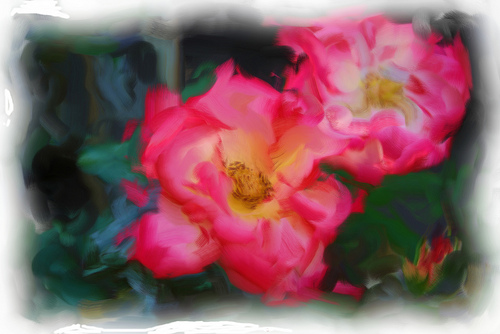

In [13]:
#Extract Rose 
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

In [18]:
## Some tulips

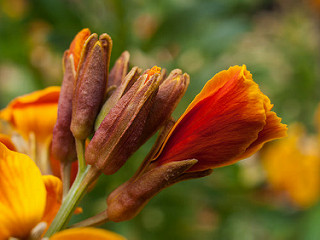

In [19]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

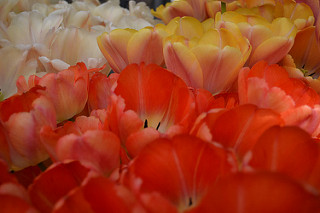

In [20]:
PIL.Image.open(str(tulips[1]))

## Load data using a Keras Utility

In [2]:
batch_size = 32
img_height = 180
img_width  = 180

In [21]:
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2, subset = "training",
                                                      seed = 123,
                                                      image_size=(img_height, img_width),
                                                      batch_size= batch_size)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.


2022-12-16 15:57:18.399608: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1040] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2022-12-16 15:57:18.403743: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1040] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2022-12-16 15:57:18.404626: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1040] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/s

In [26]:
val_ds = tf.keras.utils.image_dataset_from_directory(data_dir, 
                                                    validation_split=0.2,
                                                    subset = "validation",
                                                    seed = 123, 
                                                    image_size = (img_height, img_width),
                                                    batch_size = batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [22]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualize the Data

2022-12-16 16:03:10.181476: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2936]
	 [[{{node Placeholder/_4}}]]
2022-12-16 16:03:10.182055: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2936]
	 [[{{node Placeholder/_4}}]]


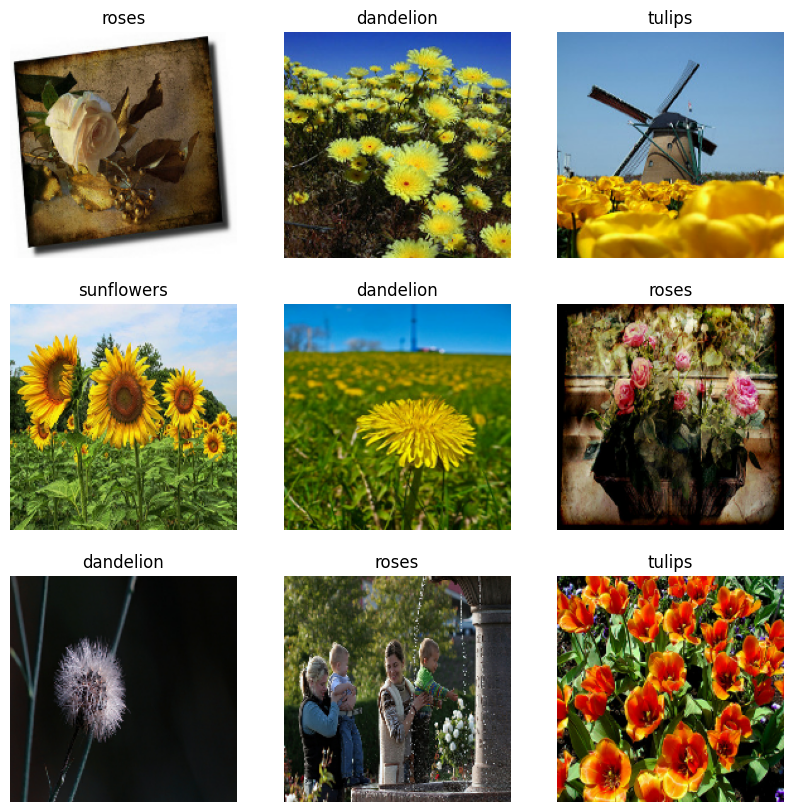

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [24]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


2022-12-16 16:06:56.139404: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2936]
	 [[{{node Placeholder/_4}}]]
2022-12-16 16:06:56.140708: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2936]
	 [[{{node Placeholder/_0}}]]


## Configure the dataset for performance

In [27]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

## Standardize the data

In [28]:
normalization_layer = layers.Rescaling(1. / 255)

In [29]:
normalized_ds = train_ds.map(lambda x,y : (normalization_layer(x),y))
image_batch , labels_batch = next(iter(normalized_ds))

first_image = image_batch[0]

# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2022-12-16 16:17:32.386234: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2936]
	 [[{{node Placeholder/_0}}]]
2022-12-16 16:17:32.386590: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2936]
	 [[{{node Placeholder/_0}}]]


0.0 0.99990207


### A basic Keras Model

In [30]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1. / 255, input_shape = (img_height, img_width,3)),
    layers.Conv2D(16,3,padding='same', activation = 'relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(32,3,padding = 'same', activation = "relu"),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64,3,padding = 'same', activation= "relu"),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    
    layers.Dense(num_classes)
    
])

In [ ]:
## Compile the Model
model.compile(optimizer='adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"])